#Setting up the environment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun 30 07:12:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons

     |████████████████████████████████| 4.3MB 15.5MB/s 
     |████████████████████████████████| 686kB 38.7MB/s 


In [ ]:
import os
import collections
import json
import numpy as np
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

# Preparing, Processing and Saving Data


In [ ]:
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir_1 = '/content/datasets/VG_100K'
images_dir_2 = '/content/datasets/VG_100K_2'
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = '/content/datasets/annotations/relationships.json'

# Download region descriptions
region_descriptions_zip = tf.keras.utils.get_file(
        "region_descriptions_zip",
        cache_dir=os.path.abspath("."),
        origin="https://visualgenome.org/static/data/dataset/region_descriptions.json.zip",
        extract=True,
    )
os.remove(region_descriptions_zip)
print("Downloaded and extracted Region Descriptions")

# Download image files
image_zip_part_1 = tf.keras.utils.get_file(
    "train_1.zip",
    cache_dir=os.path.abspath("."),
    origin="https://cs.stanford.edu/people/rak248/VG_100K_2/images.zip",
    extract=True,
    )
!cp '/content/datasets/train_1.zip''/content/drive/MyDrive/Colab Notebooks/CLIP'
os.remove(image_zip_part_1)
print("Downloaded and Extracted Images - part 1")

image_zip_part_2 = tf.keras.utils.get_file(
    "train_2.zip",
    cache_dir=os.path.abspath("."),
    origin="https://cs.stanford.edu/people/rak248/VG_100K_2/images2.zip",
    extract=True,
    )
!cp '/content/datasets/train_2.zip' '/content/drive/MyDrive/Colab Notebooks/CLIP'
os.remove(image_zip_part_2) 
print("Downloaded and Extracted Images - part 2")
print("Dataset is downloaded and extracted successfully.")


127385600/127377968 [==============================] - 5s 0us/step
Downloaded and extracted Region Descriptions
9731710976/9731705982 [==============================] - 550s 0us/step
cp: missing destination file operand after '/content/datasets/train_1.zip/content/drive/MyDrive/Colab Notebooks/CLIP'
Try 'cp --help' for more information.
Downloaded and Extracted Images - part 1
5471666176/5471658058 [==============================] - 413s 0us/step
Downloaded and Extracted Images - part 2
Dataset is downloaded and extracted successfully.


In [ ]:
with open('/content/datasets/region_descriptions.json', "r") as f:
    region_description = json.load(f)

In [ ]:
images_in_images_dir_1 = set(os.listdir(images_dir_1))
images_in_images_dir_2 = set(os.listdir(images_dir_2))
def expand_path(id):
    if f'{id}.jpg' in images_in_images_dir_1:
        return os.path.join(images_dir_1, f"{id}.jpg")
    elif f'{id}.jpg' in images_in_images_dir_2:
        return os.path.join(images_dir_2, f"{id}.jpg")
    return None

In [ ]:
image_path_to_all_phrases = collections.defaultdict(list)
for id in region_description:
    image_path = expand_path(id['id'])
    phrases = []
    for element in id['regions']:
        phrases.append(element['phrase'])
    
    image_path_to_all_phrases[image_path] = phrases

In [ ]:
image_paths = list(image_path_to_all_phrases.keys())
print(f"Number of images : {len(image_paths)}")

Number of images : 108077


In [ ]:
print(len(os.listdir('/content/datasets/VG_100K')) + len(os.listdir('/content/datasets/VG_100K_2')))

108249


In [ ]:
for i, item in enumerate(image_path_to_all_phrases):
    if i == 5: break
    print(item)
    for j, phrase in enumerate(image_path_to_all_phrases[item]):
        if j==3 : break
        print(phrase)
    print(len(image_path_to_all_phrases[item]))
    print('*' * 30)

/content/datasets/VG_100K_2/1.jpg
the clock is green in colour
shade is along the street 
man is wearing sneakers
262
******************************
/content/datasets/VG_100K/2.jpg
walk sign is lit up
man wearing silver backpack
red car parked on road
256
******************************
/content/datasets/VG_100K/3.jpg
multi-line office phone system
electrical and data line outlets
desktop CPU, monitor and keyboard
255
******************************
/content/datasets/VG_100K/4.jpg
Blue curtains with sailboats on them.
A black chair with blue padding.
A white sofa pillow. 
257
******************************
/content/datasets/VG_100K/5.jpg
the floor is wooden
white cables are on the floor
wooden chairs are empty
248
******************************


In [ ]:
train_size = 80000
valid_size = 8000
phrases_per_image = 6
sentences_per_phrase = 1
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, 'train')

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid_1")

tf.io.gfile.makedirs(tfrecords_dir)

In [ ]:
phrases = image_path_to_all_phrases['/content/datasets/VG_100K/10.jpg'][:phrases_per_image * sentences_per_phrase]
phrases = [phrases[i*sentences_per_phrase]  for i in range(phrases_per_image)]
phrases

['headphones are on the desk',
 'a black charger is on the cable',
 'cpus are on the floor',
 'the wall is green',
 'Headphones laying on table',
 'Cork board hanging on the wall']

In [ ]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def create_example(image_path, phrase):
    feature = {
        'phrase' : bytes_feature(phrase.encode()),
        'raw_image' : bytes_feature(tf.io.read_file(image_path).numpy())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [ ]:
def write_tfrecords(file_name, image_paths):
    phrase_list = []
    image_path_list = []
    for image_path in image_paths:
        phrases = image_path_to_all_phrases[image_path][:phrases_per_image * sentences_per_phrase]
        try:
            phrases = [phrases[i*sentences_per_phrase] for i in range(phrases_per_image)]
        except:
            print(phrases)
            print(image_path_to_all_phrases[image_path])
            continue
        phrase_list.extend(phrases)
        image_path_list.extend([image_path] * len(phrases))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], phrase_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


In [ ]:
def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in range(num_files):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

In [ ]:
train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

In [ ]:
valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

In [ ]:
!rm -r '/content/datasets/VG_100K'
!rm -r '/content/datasets/VG_100K_2'

In [ ]:
!mv --backup=none '/content/datasets/tfrecords' '/content/drive/MyDrive/Colab Notebooks/CLIP/train_tfrecords'

In [ ]:
!mv --backup=none '/content/datasets/tfrecords' '/content/drive/MyDrive/Colab Notebooks/CLIP/valid_tfrecords'

# Retrieve Saved Data

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/CLIP/train_tfrecords' '/content'

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/CLIP/valid_tfrecords' '/content'

# Preparing Dataset for Training and Eval

In [ ]:
feature_description = {
    'phrase' : tf.io.FixedLenFeature([], tf.string),
    'raw_image' : tf.io.FixedLenFeature([], tf.string)
}

def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop('raw_image')
    features['image'] = tf.image.resize(tf.image.decode_jpeg(raw_image, channels = 3), size = (299, 299))
    return features

In [ ]:
def get_dataset(file_pattern, batch_size):
    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
             num_parallel_calls = tf.data.experimental.AUTOTUNE, 
             deterministic = False
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
        .batch(batch_size)
    )

# Creating the model

In [ ]:
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    projected_embeddings = layers.Dense(units = projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

## Image Encoder

In [ ]:
def create_vision_encoder(num_projection_layers, projection_dims,
                          dropout_rate, trainable = False):

    net = tf.keras.applications.EfficientNetB5(include_top=False, 
                                                   weights='imagenet',
                                                   pooling='avg')
    #net.summary()
    for layer in net.layers:
        layer.trainable = trainable
    
    inputs = layers.Input(shape = (299, 299, 3), name = 'image_input')
    net_input = tf.keras.applications.efficientnet.preprocess_input(inputs)
    embeddings = net(net_input)
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    return keras.Model(inputs, outputs, name = 'vision_encoder')

## Text Encoder

In [ ]:
def create_text_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'text_input')
    
    preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2')
    encoder_inputs = preprocessor(text_input)
    encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
    encoder.trainable = True
    embeddings = encoder(encoder_inputs)["pooled_output"]   
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)   

    return keras.Model(text_input, outputs, name = 'text_encoder')


## Dual Encoder

In [ ]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature = 1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name = 'loss')

    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def call(self, features, training = False):
        with tf.device("/gpu:0"):
            phrase_embeddings = text_encoder(features['phrase'], training = training)
            image_embeddings = image_encoder(features['image'], training = training)
        return phrase_embeddings, image_embeddings
    
    def compute_loss(self, phrase_embeddings, image_embeddings):
        logits = (tf.matmul(phrase_embeddings, image_embeddings, transpose_b=True)/self.temperature)
        image_similarity = tf.matmul(image_embeddings, image_embeddings, transpose_b=True)
        phrase_similarity = tf.matmul(phrase_embeddings, phrase_embeddings, transpose_b=True)
        targets = keras.activations.softmax((phrase_similarity + image_similarity) / (2 * self.temperature)) 
        # The Diagonal of this matrix should be approx 1s and every other element should be close to 0
        phrase_loss = keras.losses.categorical_crossentropy(y_true=targets, y_pred=logits, from_logits=True)
        images_loss = keras.losses.categorical_crossentropy(y_true = tf.transpose(targets), y_pred = tf.transpose(logits), from_logits=True)
        
        return (phrase_loss + images_loss)/2
    
    def train_step(self, features):
        with tf.GradientTape() as tape:
            phrase_embeddings, image_embeddings = self(features, training = True)
            loss = self.compute_loss(phrase_embeddings, image_embeddings)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}
    
    def test_step(self, features):
        phrase_embeddings, image_embeddings = self(features, training = False)
        loss = self.compute_loss(phrase_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

##Training

In [ ]:
num_epochs = 10
batch_size = 128
train_example_count = 80000
image_encoder = create_vision_encoder(
    num_projection_layers=2, projection_dims=512, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=2, projection_dims=512, dropout_rate=0.1
)

In [ ]:
dual_encoder = DualEncoder(text_encoder, image_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001)
)

In [ ]:
#dual_encoder.load_weights('/content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_test_version_5.h5')

In [ ]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (phrase-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
train_dataset = get_dataset(os.path.join('/content/datasets/tfrecords', "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join('/content/datasets/tfrecords', "valid_*.tfrecord"), batch_size)

# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=1
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=False
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_final_test.h5', monitor = 'val_loss', verbose = 1, save_weights_only = True, save_best_only = True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)
print("Training completed. Saving vision and text encoders...")
image_encoder.save("image_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 1
Number of examples (phrase-image pairs): 80000
Batch size: 128
Epoch 1/10
3750/3750 [==============================] - 6469s 2s/step - loss: 67.4317 - val_loss: 5.2098

Epoch 00001: val_loss improved from inf to 5.20985, saving model to /content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_final_test.h5
Epoch 2/10
3750/3750 [==============================] - 6460s 2s/step - loss: 4.5172 - val_loss: 3.2701

Epoch 00002: val_loss improved from 5.20985 to 3.27010, saving model to /content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_final_test.h5
Epoch 3/10
3750/3750 [==============================] - 6449s 2s/step - loss: 3.0631 - val_loss: 2.8897

Epoch 00003: val_loss improved from 3.27010 to 2.88973, saving model to /content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_final_test.h5
Epoch 4/10
3750/3750 [==============================] - 6443s 2s/step - loss: 2.7823 - val_loss: 2.7980

Epoch 00004: val_loss improved 

## plotting history

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
!cp -r '/content/image_encoder' '/content/drive/MyDrive/Colab Notebooks/CLIP/final'

In [ ]:
!cp -r '/content/text_encoder' '/content/drive/MyDrive/Colab Notebooks/CLIP/final'

# Zero Shot Classification Testing on Pascal VOC

<img src="https://openaiassets.blob.core.windows.net/$web/clip/draft/20210104b/overview-b.svg" width="400" height="400" />

## Loading and Exploring Models

In [ ]:
image_encoder = create_vision_encoder(
    num_projection_layers=2, projection_dims=512, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=2, projection_dims=512, dropout_rate=0.1
)

115269632/115263384 [==============================] - 3s 0us/step


In [ ]:
dual_encoder = DualEncoder(text_encoder, image_encoder, temperature=0.05)

valid_dataset = get_dataset(os.path.join('/content/datasets/tfrecords', "valid_*.tfrecord"), batch_size)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0001)
)
dual_encoder.evaluate(valid_dataset)
dual_encoder.load_weights('/content/drive/MyDrive/Colab Notebooks/CLIP/Clip-on-visualgenome-model_final_test.h5')

375/375 [==============================] - 576s 1s/step - loss: 829.7008


In [ ]:
dual_encoder.evaluate(valid_dataset)

375/375 [==============================] - 557s 1s/step - loss: 2.6814


2.6813814640045166

In [ ]:
text_encoder = dual_encoder.layers[0]
image_encoder = dual_encoder.layers[1]

In [ ]:
image_encoder.summary()

Model: "vision_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb5 (Functional)     (None, 2048)         28513527    image_input[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          1049088     efficientnetb5[0][0]             
__________________________________________________________________________________________________
tf.nn.gelu_4 (TFOpLambda)       (None, 512)          0           dense_6[0][0]                    
_____________________________________________________________________________________

In [ ]:
image_encoder = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/CLIP/final/image_encoder")

In [ ]:
text_encoder = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/CLIP/final/text_encoder")

# Preparing Pascal Voc dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
dataset_name = 'voc'
ds_test, ds_info = tfds.load(dataset_name, split = ['test'], with_info=True)
ds_test = ds_test[0]

In [ ]:
size = (299, 299)
ds_test = ds_test.map(lambda data:( [
                                     tf.image.resize(data['image'], size), 
                                     tf.reduce_sum(tf.one_hot(data['labels'], 20),
                                                   axis = 0)
                                     ]
                                    ))

In [ ]:
images = []
labels = []
for i, element in tqdm(enumerate(ds_test.as_numpy_iterator())):
    label = np.zeros((20, 1))
    images.append(element[0])
    for j in range(20):
        if j in element[1]:
            label[j] = 1
    labels.append(label)

4952it [00:08, 560.49it/s]


In [ ]:
ds_test = ds_test.shuffle(buffer_size=100).batch(64).prefetch(3)

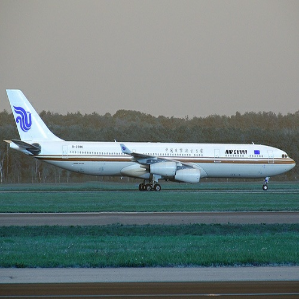

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(20,), dtype=float32)


In [ ]:
for img, label in ds_test:
    cv2_imshow(img[0].numpy())
    print(label[0])
    break

## Zero - Shot Classification

In [ ]:
cats = ds_info.features['objects']['label'].names
cats

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [ ]:
category_embeddings = text_encoder.predict(np.array(cats))

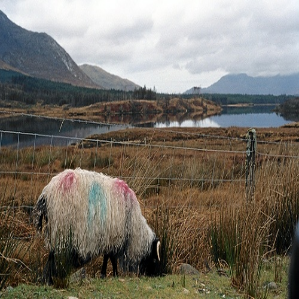

[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (0, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (0, 'person'), (0, 'pottedplant'), (1, 'sheep'), (0, 'sofa'), (0, 'train'), (0, 'tvmonitor')]
[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (0, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (0, 'person'), (0, 'pottedplant'), (1, 'sheep'), (0, 'sofa'), (0, 'train'), (0, 'tvmonitor')]


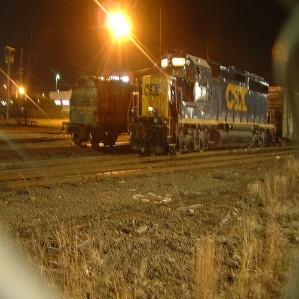

[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (0, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (0, 'person'), (0, 'pottedplant'), (0, 'sheep'), (0, 'sofa'), (1, 'train'), (0, 'tvmonitor')]
[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (0, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (0, 'person'), (0, 'pottedplant'), (0, 'sheep'), (0, 'sofa'), (1, 'train'), (0, 'tvmonitor')]


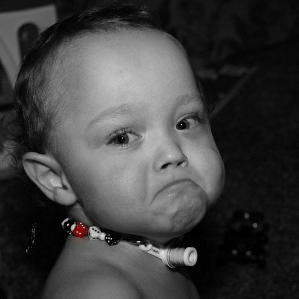

[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (1, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (0, 'person'), (0, 'pottedplant'), (0, 'sheep'), (0, 'sofa'), (0, 'train'), (0, 'tvmonitor')]
[(0, 'aeroplane'), (0, 'bicycle'), (0, 'bird'), (0, 'boat'), (0, 'bottle'), (0, 'bus'), (0, 'car'), (0, 'cat'), (0, 'chair'), (0, 'cow'), (0, 'diningtable'), (0, 'dog'), (0, 'horse'), (0, 'motorbike'), (1, 'person'), (0, 'pottedplant'), (0, 'sheep'), (0, 'sofa'), (0, 'train'), (0, 'tvmonitor')]


In [ ]:
for imgs, labels in ds_test:
    image_embeddings = image_encoder.predict(imgs)
    pred = tf.matmul(category_embeddings, image_embeddings, transpose_b=True)    
    for example in range(3):
        a = pred[:,example].numpy()
        b = tf.nn.softmax(a).numpy()
        c = (a - a.min()) / (a.max() - a.min())
        d = np.where(c>0.8, 1, 0)
        img = imgs[example].numpy()[...,::-1]
        cv2_imshow(img)
        print([(d[n], cats[n]) for n in range(20)])
        print([(int(labels[example].numpy()[n]), cats[n]) for n in range(20)])
    break

In [ ]:
def evaluate(threshold):
    true_pos, true_neg, false_pos, false_neg = 0,0,0,0
    
    for imgs, labels in ds_test:
        image_embeddings = image_encoder.predict(imgs)
        pred = tf.matmul(category_embeddings, image_embeddings, transpose_b=True)
        
        for example in range(len(image_embeddings)):
            a = pred[:,example].numpy()
            b = (a - a.min()) / (a.max() - a.min())
            y_pred = np.where(b>threshold, 1.0, 0.0)
            y_true = labels[example].numpy()

            c = np.where(y_pred == 1)[0].tolist()
            d = np.where(y_true == 1)[0].tolist()
            
            tp, tn, fp, fn = 0,0,0,0
        
            for i in c:
                if i in d: tp +=1
                else: fp +=1 
        
            for j in d:
                if j not in c: fn += 1
        
            tn += 20 - (fp + fn) - tp
            true_pos += tp
            true_neg += tn
            false_pos += fp
            false_neg += fn
    
    accuracy = round((true_pos+true_neg) / (true_pos + true_neg + false_pos + false_neg) * 100, 2)
    sensitivity = round(true_pos / (true_pos + false_neg) * 100, 2)
    specificity = round(true_neg / (true_neg + false_pos) * 100, 2)
    
    print(f'\n accuracy = {accuracy} % \n sensitivity = {sensitivity} % \n specificity = {specificity} %')
    
    return (accuracy, sensitivity, specificity), (true_pos, true_neg, false_pos, false_neg)

In [ ]:
threshold_range = [0.5, 0.6, 0.7, 0.8, 0.9]
threshold_stats = {}
threshold_values = {}
for threshold in threshold_range:
    print(f'Eval when threshold = {threshold}')
    stats, values = evaluate(threshold)
    threshold_stats[threshold] = stats
    threshold_values[threshold] = values 
    print('*' * 80)
    print()

Eval when threshold = 0.5

 accuracy = 75.3 % 
 sensitivity = 91.98 % 
 specificity = 73.91 %
********************************************************************************

Eval when threshold = 0.6

 accuracy = 84.26 % 
 sensitivity = 84.93 % 
 specificity = 84.2 %
********************************************************************************

Eval when threshold = 0.7

 accuracy = 89.79 % 
 sensitivity = 77.62 % 
 specificity = 90.8 %
********************************************************************************

Eval when threshold = 0.8

 accuracy = 93.01 % 
 sensitivity = 69.42 % 
 specificity = 94.98 %
********************************************************************************

Eval when threshold = 0.9

 accuracy = 94.74 % 
 sensitivity = 60.78 % 
 specificity = 97.57 %
********************************************************************************

